In [1]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV

In [2]:
# Reset pseudo random number generator so that the results are reproducible.
seed = 42
np.random.seed(seed)

### Generate target function and its noisy version.

In [3]:
# Sets the number of examples.
N = 30

# Attribute.
x = np.sort(2*np.random.rand(N, 1) - 1, axis=0)

# Target function.
y = 1 + 0.5*x + 2*(x**2)

# Noise.
w = 0.3*np.random.randn(N, 1)

# Noisy function.
y_noisy = y + w

# Validation samples.
Ntest = 100
x_test = np.linspace(-1, 1, Ntest).reshape(Ntest, 1)
y_test = 1 + 0.5*x_test + 2*(x_test**2) + 0.3*np.random.randn(Ntest, 1)

In [4]:
print('Média das amostras da função observável:', np.mean(y_noisy))

Média das amostras da função observável: 1.530915117847102


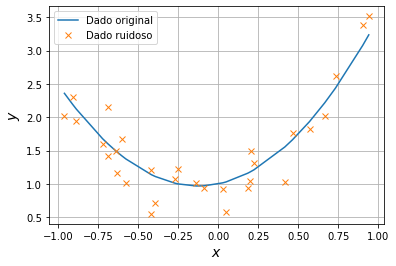

In [5]:
# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("target_function.png", dpi=600)

#Show the plot.
plt.show()

### Define the polinomial order

In [6]:
# Polynomial order.
model_order = 15

### Define a list of regularization factors to be tested

In [7]:
# Regularization factor.
lambdas = [0, 0.0076, 1]

### LASSO regression with SciKit-Learn 

Usamos a classe `Lasso` para realizar a regressão LASSO.

**Observações**.: 

+ É importante sempre escalonar os atributos antes de executar qualquer tipo de regressão com regularização.

+ O parâmetro `alpha` da classe `Lasso` é o fator de regularização, $\lambda$, e não o passo de aprendizagem.

Lambda: 0.0000e+00:
[1.53091512]
[-3.26619148e-01  6.26027965e+00  9.11715885e+00 -8.93092859e+01
 -9.13730327e+01  5.26147653e+02  5.43742416e+02 -1.51291387e+03
 -1.71566113e+03  2.27078228e+03  2.80890380e+03 -1.70290215e+03
 -2.25122856e+03  5.02976634e+02  6.97684255e+02]
---------------------------------------------
Lambda: 7.6000e-03:
[1.53091512]
[ 0.21805523  0.60770517  0.09951701  0.02276031  0.01384661  0.
  0.00884529  0.          0.00634401 -0.          0.00464897 -0.
  0.00366414 -0.          0.00310918]
---------------------------------------------
Lambda: 1.0000e+00:
[1.53091512]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
---------------------------------------------


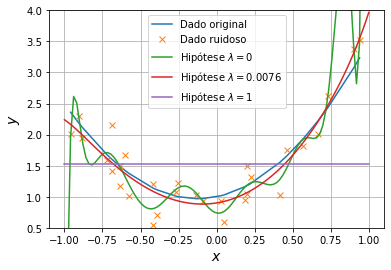

In [8]:
include_bias = True

# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
for i in range(0,len(lambdas)):

    # Instantiate a polynomial with the given degree.
    poly_features = PolynomialFeatures(degree=model_order, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    std_scaler = StandardScaler()
    # Instantiate a Lasso regressor.
    # tol: a otimização continua enquanto as atualizações não forem menores que o valor definido para 'tol'.
    #      Quanto menor o valor de 'tol', mais precisa será a solução final, mas o treinamento levará mais tempo.
    # lambda = 0: devido a instabilidades numéricas, a documentação da classe Lasso não recomenda seu uso quando lambda = 0.
    reg = Lasso(alpha=lambdas[i], tol=1, random_state=seed) if lambdas[i] > 0 else LinearRegression()
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)
    # Print coefs
    print('Lambda: %1.4e:' % (lambdas[i]))
    print(model.named_steps['reg'].intercept_)
    if lambdas[i] > 0:
        print(model.named_steps['reg'].coef_[1:model_order+1])
    else:
        print(model.named_steps['reg'].coef_[0, 1:model_order+1])
    # Predict.
    y_test_regul = model.predict(x_test)
    print('---------------------------------------------')
    
    # Plot prediction.
    plt.plot(x_test, y_test_regul, label='Hipótese $\lambda=$'+str(lambdas[i]))
    
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.ylim(0.5,4)
# Save figure
#plt.savefig("lasso_regression.png", dpi=600)

#Show the plot.
plt.show()

#### Conclusões:

+ Valores pequenos de $\lambda$ fazem LASSO se comportar como regressão tradicional e valores muito grandes fazem os pesos serem anulados (**região de factibilidade nula**).

+ A regularização com norma L1 tem como **vantagem a produção de modelos esparsos**.

    + Ou seja, vários elementos do vetor de pesos acabam sendo anulados, indicando que os atributos correspondentes são irrelevantes para o processo de regressão.

+ Isso sugere a ocorrência implícita de um processo de **seleção automática de atributos**, que leva a modelos mais regulares, ou seja, menos complexos.

+ **Desvantagem**: como a norma L1 não possui derivada no ponto $a_i=0\;, \forall i$, o problema da minimização **não possui solução em forma fechada**, mas **pode ser implementado com o gradiente descendente**.

+ Utiliza-se técnicas de **validação cruzada** para encontrar o valor ideal de  $\lambda$.


### Weight variation versus lambda (i.e., regularization factor)

In [9]:
include_bias = True

M = 5000
lambdas = np.linspace(1e-4, 1, M)

a_hist = np.zeros((model_order, M))
norm_hist = np.zeros((1, M))
error_test = []

for i in range(0,len(lambdas)):
    # Instantiate a polynomial with the given degree.
    poly_features = PolynomialFeatures(degree=model_order, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    std_scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = Lasso(alpha=lambdas[i], tol=1, random_state=seed) if lambdas[i] > 0 else LinearRegression()
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)
    a = model.named_steps['reg'].coef_[1:model_order+1]
    a_hist[:,i] = a
    norm_hist[:,i] = np.linalg.norm(a, ord=1)
    # Predict.
    y_test_regul = model.predict(x_test)
    error_test.append((mean_squared_error(y_test, y_test_regul)))

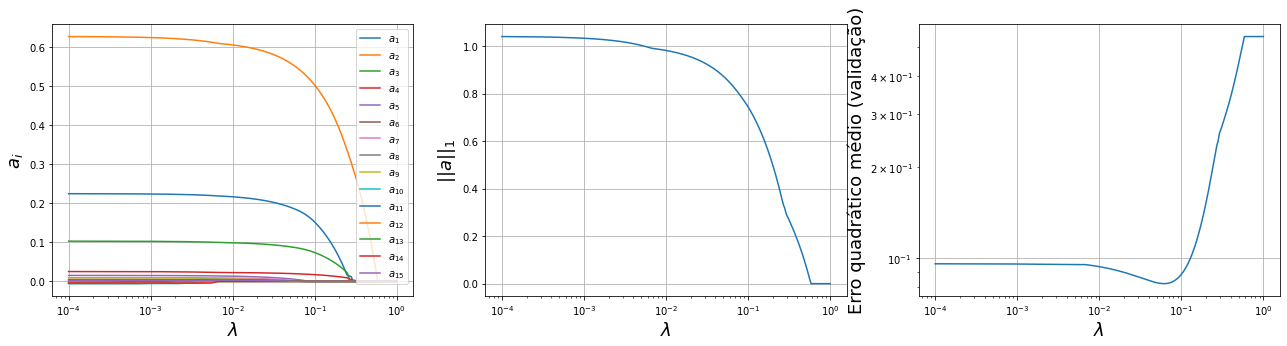

In [10]:
# Create figure.
fig = plt.figure(figsize=(22,5))

# Plot weight.
ax = plt.subplot(1, 3, 1)
for i in range(0,model_order): 
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('$a_i$', fontsize=18)
plt.legend(loc='upper right')
plt.grid()
# Save figure
#plt.savefig("lasso_regression_pesos.png", dpi=600)

# Plot norm.
ax = plt.subplot(1, 3, 2)
plt.plot(lambdas, norm_hist[0,:])
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('$||a||_1$', fontsize=18)
plt.grid()
# Save figure
#plt.savefig("lasso_regression_norma.png", dpi=600)

# Plot error.
ax = plt.subplot(1, 3, 3)
plt.plot(lambdas, error_test)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('Erro quadrático médio (validação)', fontsize=18)
plt.grid()
# Save figure
#plt.savefig("lasso_regression_mse.png", dpi=600)

#Show the plot.
plt.show()

+ Quando $\lambda$ é aproximadamente igual a 0.6, a norma L1 dos pesos é praticamente igual a 0.

+ Para valores de $\lambda$ menores do que $0.007$, o modelo **sobreajusta**, pois a área de factibilidade é muito grande.

+ Quando $\lambda$ é aproximadamente igual a $0.007$, o modelo se aproxima da função geradora (menor erro). Relação de compromisso entre variância e viés.

+ Para valores de $\lambda$ maiores do que $0.007$, o modelo tende ao valor constante igual à média dos dados de treinamento (reta), o que faz o erro aumentar, pois o modelo **subajusta** (área de factibilidade é muito pequena).

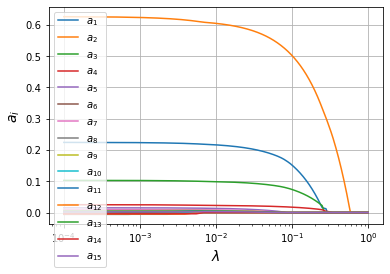

In [11]:
# Plot weight.
for i in range(0,model_order): 
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$a_i$', fontsize=14)
plt.legend(loc='upper left')
plt.grid()

#Show the plot.
plt.show()

### Using cross-validation for finding the best $\lambda$

Usamos a classe `LassoCV` para encontrar o valor ideal de $\lambda$.

#### Ajuste grosso

In [12]:
M = 1000
alphas = np.logspace(-5, 2, M)

# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=model_order, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a Ridge regressor.
reg = LassoCV(alphas=alphas, tol=1, random_state=seed)
# Create a pipeline of actions.
clf = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

clf.fit(x, y_noisy.ravel())

Pipeline(steps=[('poly', PolynomialFeatures(degree=15)),
                ('scaler', StandardScaler()),
                ('reg',
                 LassoCV(alphas=array([1.00000000e-05, 1.01626509e-05, 1.03279473e-05, 1.04959323e-05,
       1.06666496e-05, 1.08401436e-05, 1.10164595e-05, 1.11956432e-05,
       1.13777413e-05, 1.15628013e-05, 1.17508713e-05, 1.19420003e-05,
       1.21362380e-05, 1.23336350e-05, 1.25342427e-05, 1.27381132e-0...
       6.89983712e+01, 7.01206359e+01, 7.12611543e+01, 7.24202233e+01,
       7.35981448e+01, 7.47952252e+01, 7.60117762e+01, 7.72481145e+01,
       7.85045620e+01, 7.97814457e+01, 8.10790981e+01, 8.23978568e+01,
       8.37380654e+01, 8.51000725e+01, 8.64842328e+01, 8.78909065e+01,
       8.93204600e+01, 9.07732653e+01, 9.22497005e+01, 9.37501502e+01,
       9.52750047e+01, 9.68246612e+01, 9.83995230e+01, 1.00000000e+02]),
                         random_state=42, tol=1))])

In [13]:
clf['reg'].alpha_

0.007225349491787214

#### Ajuste fino

In [14]:
alphas = np.linspace(clf['reg'].alpha_/10, clf['reg'].alpha_*10, M)

# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=model_order, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a Ridge regressor.
reg = LassoCV(alphas=alphas, tol=1, random_state=seed)
# Create a pipeline of actions.
clf = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

clf.fit(x, y_noisy.ravel())

Pipeline(steps=[('poly', PolynomialFeatures(degree=15)),
                ('scaler', StandardScaler()),
                ('reg',
                 LassoCV(alphas=array([0.00072253, 0.00079414, 0.00086574, 0.00093734, 0.00100895,
       0.00108055, 0.00115215, 0.00122375, 0.00129536, 0.00136696,
       0.00143856, 0.00151016, 0.00158177, 0.00165337, 0.00172497,
       0.00179657, 0.00186818, 0.00193978, 0.00201138, 0.00208298,
       0.00215459, 0.00222...
       0.07017702, 0.07024862, 0.07032023, 0.07039183, 0.07046343,
       0.07053503, 0.07060664, 0.07067824, 0.07074984, 0.07082144,
       0.07089305, 0.07096465, 0.07103625, 0.07110785, 0.07117946,
       0.07125106, 0.07132266, 0.07139426, 0.07146587, 0.07153747,
       0.07160907, 0.07168067, 0.07175228, 0.07182388, 0.07189548,
       0.07196708, 0.07203869, 0.07211029, 0.07218189, 0.07225349]),
                         random_state=42, tol=1))])

In [15]:
clf['reg'].alpha_

0.007596380952176286

### Comparing the results

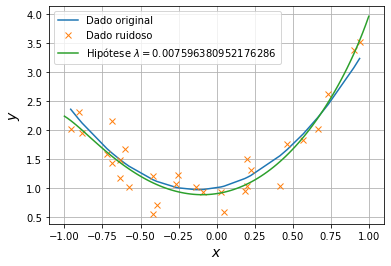

In [16]:
y_test_pred = clf.predict(x_test)

# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.plot(x_test, y_test_pred, label='Hipótese $\lambda=$'+str(clf['reg'].alpha_))
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#plt.axis([-1, 0, 1])
#Show the plot.
plt.show()

### Referências

[1] "what is max_iter and tol in Lasso Regularizer sklearn", https://stackoverflow.com/questions/66487819/what-is-max-iter-and-tol-in-lasso-regularizer-sklearn